
EE4414 Team Practice
==============================================

In this team practice, you will design Convolutional Neural Network(s) to classify food images.




In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()   # interactive mode

C:\Users\Lam Yik Hong\AppData\Roaming\Python\Python311\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [4]:
# Define the dataset class
directory = 'E:\Projects\IE4414\data\sg_food'
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [6]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

data_dir = os.path.join('data', 'sg_food')
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [7,8,9,10,11]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [7, 8, 9, 10, 11]
    name: ['Oyster Omelette', 'Roast Meat Rice', 'Roti Prata', 'Satay', 'Wanton Mee']


## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



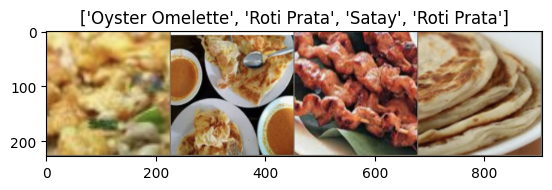

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=24):
    # TODO
    return model

## 4. Training and validating the model

Train your model for minimum 3 epochs.

### 4.1 Loading pretrained model and defining new classfier layer


In [ ]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

# (code)

# 2. Modify the pretrain model for your task.

# (code)

# 3. Choose your loss function, optimizer, etc.

# (code)


### 4.2 Printing and visualizing the modified model

In [ ]:
# TODO
# print(model)

In [ ]:
# TODO
# from torchsummary import summary
# summary(model, input_size=xxx)

### 4.3 Training using train data and evaluating using validation data

Train your model for minimum 3 epochs.

In [ ]:
# TODO 
# model_resnet18 = train_model(...)

## 5. Loading test data

Define the dataset and dataloader for testing.

In [ ]:
test_dir = os.path.join('data', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

In [ ]:
# TODO

# num_images = 4

# (code)

# with torch.no_grad():
    # Predict on the test set

    # (code)

    # Print the output images and labels
    
    # (code)


## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.

In [ ]:
model_resnet18.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))
